In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1,10),
        #nn.BatchNorm1d(10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward(self, x):
        N = self.layers(x)
        return N

In [3]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    torch.nn.utils.clip_grad_value_(model.parameters(), 2)
    optimizer.step(closure)  

tensor([1.5172e-08])
torch.Size([200, 1])
tensor([1.0000])


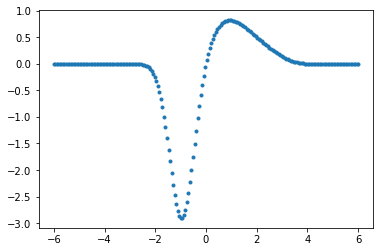

In [4]:
upper_r = 6
lower_r = -6
steps = 200
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])

Phi_0 = torch.Tensor(np.loadtxt("file1.txt")).reshape(200,1)
norm = torch.sqrt(torch.trapezoid(Phi_0[100:]**2,R_train[100:],dim=0))
print(norm)
Phi_0 = Phi_0/norm
#Phi_0 = Phi_0.detach()
print(Phi_0.shape)
print(torch.trapezoid(Phi_0[100:]**2,R_train[100:],dim=0))
plt.plot(R_train.detach().numpy(), Phi_0.detach().numpy(), ".")

In [5]:
beta = 2
global Z
Z = 1
global e
#e = -1.602e-19
e = -1
global hbar
#hbar = 1.054e-34
hbar = 1
global m
#m = 9.109e-31
m = 1
global l
l = 0
#global Phi_0

V = lambda r: -(Z*e**2)/r
Phi_aux = lambda r: r * torch.exp(-beta*r**2) * model.forward(r)
Phi_t = lambda r: Phi_aux(r) - Phi_0*torch.trapezoid(Phi_0[100:]*Phi_aux(r)[100:], r[100:],dim=0)

In [6]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear)):
            nn.init.xavier_normal_(m.weight.data)

norm =  tensor([0.0032], grad_fn=<DivBackward1>)
energy =  tensor([3.7785], grad_fn=<DivBackward0>)
loss =  tensor([600.0003], grad_fn=<DivBackward0>)


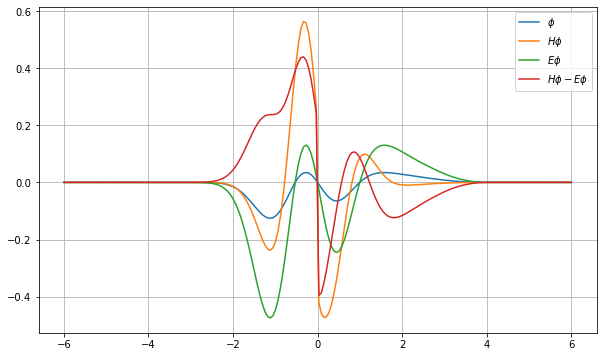

In [7]:
f1 = lambda r: r*torch.exp(-beta*r**2) 
f2 = lambda r: r*torch.exp(-beta*r**2) * model.forward(R_train) 
plt.figure(figsize=(10,6))
#plt.plot(R_train.detach().numpy(), Phi_0.detach().numpy(), label="$\phi_0$")
model = NeuralNetwork()
initialize_weights(model)
#plt.plot(R_train.detach().numpy(),f1(R_train).detach().numpy())
#plt.plot(R_train.detach().numpy(),f2(R_train).detach().numpy())
R_train.requires_grad = True
Phi = Phi_t(R_train)  
#plt.plot(R_train.detach().numpy(), Phi_aux(R_train).detach().numpy(), ".", label="$\phi_{aux}$")
#integral = Phi_0*torch.trapezoid(Phi_0[100:]*Phi_aux(R_train)[100:], R_train[100:],dim=0)
#plt.plot(R_train.detach().numpy(), integral.detach().numpy(), label="integral")  
plt.plot(R_train.detach().numpy(), Phi.detach().numpy(), label="$\phi$")
Phi_t_r = torch.autograd.grad(Phi, R_train, grad_outputs=torch.ones_like(Phi), create_graph=True)[0]
Phi_t_r_r = torch.autograd.grad(Phi_t_r, R_train, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
H_Phi = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*R_train**2) + V(R_train))*Phi
plt.plot(R_train.detach().numpy(), H_Phi.detach().numpy(), label="$H\phi$")    
norm_sqr = torch.trapezoid(Phi[100:]**2,R_train[100:],dim=0) # integral over r=0 to 6
print("norm = ",norm_sqr)
prom = Phi.size()[0]
global E
E = torch.trapezoid(Phi[100:]*H_Phi[100:],R_train[100:],dim=0)/norm_sqr 
print("energy = ",E)
plt.plot(R_train.detach().numpy(), E.detach().numpy()*Phi.detach().numpy(), label="$E\phi$")
plt.plot(R_train.detach().numpy(), H_Phi.detach().numpy() - E.detach().numpy()*Phi.detach().numpy(), 
                                                        label="$H\phi-E\phi$")
loss = (torch.mean((H_Phi[100:] - E*Phi[100:])**2)*prom)/norm_sqr
print("loss = ",loss)
#plt.xlim(-1,6)
#plt.ylim(-1,1)
plt.grid()
plt.legend()
plt.show()

In [8]:
def loss_fn(r):
    r.requires_grad = True
    
    Phi = Phi_t(r)    
    Phi_t_r = torch.autograd.grad(Phi, r, grad_outputs=torch.ones_like(Phi), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    H_Phi = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*r**2) + V(r))*Phi
    
    norm = torch.trapezoid(Phi[100:]**2,r[100:],dim=0) # integral over r=0 to 6

    prom = Phi.size()[0]
    
    global E
    E = torch.trapezoid(Phi[100:]*H_Phi[100:],r[100:],dim=0)/norm 
    
    
    return (torch.mean((H_Phi[100:] - E*Phi[100:])**2)*prom)/norm #multiply by m to avoit division by m in the mean function of torh 

In [9]:
upper_r = 6
lower_r = -6
steps = 200
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epoch = 50000
lr1 = 8e-2
lr2 = 8e-4 
Phis_t = []
Es = []
lss = []
epochs = []
lr = lr1


start = time.time()

model = NeuralNetwork().to(device)
initialize_weights(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr1)
for t in range(epoch+1):
    loss = loss_fn(R_train.to(device))
    print(f"Epoch {t+1}\n ---------------------- loss: {loss}")
    training(R_train, loss_fn, optimizer)
    if t%100 == 0:
        Phis_t.append(Phi_t(R_train).detach().numpy())
        Es.append(E.detach().numpy())
        lss.append(loss.detach().numpy())
        epochs.append(t)
'''optimizer = torch.optim.Adam(model.parameters(), lr=lr2)
for t in range(int(epoch/2)+1,epoch+1):
    loss = loss_fn(R_train.to(device))
    print(f"Epoch {t+1}\n ---------------------- loss: {loss}")
    training(R_train, loss_fn, optimizer)
    if t%100 == 0:
        Phis_t.append(Phi_t(R_train).detach().numpy())
        Es.append(E.detach().numpy())
        lss.append(loss.detach().numpy())
        epochs.append(t)'''
Es = np.squeeze(Es)
lss = np.squeeze(lss)
Phis_t = np.squeeze(Phis_t)
print("Done!")

end = time.time()
print(end - start)

Epoch 1
 ---------------------- loss: tensor([687.4312], grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([546.7915], grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([476.5134], grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([406.5007], grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([328.2938], grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([319.6220], grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([316.8300], grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([296.4611], grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([300.2778], grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([305.4723], grad_fn=<DivBackward0>)
Epoch 11
 ---------------------- loss: tensor([307.3448], grad_fn=<DivBackward0>)
Epoch 12
 ---------------------- loss: tensor([306.1950], grad_fn=<DivBackward0>)
Epoch 13
 ---------------

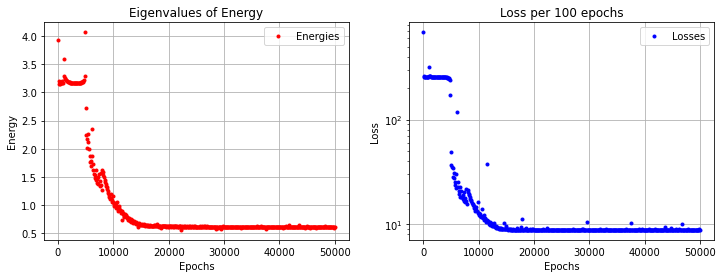

In [10]:
plt.subplots(1,2,figsize=(12,4))
plt.subplot(121)
plt.plot(epochs, Es, "r.", label="Energies")
plt.title("Eigenvalues of Energy")
#plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.grid()
plt.legend(loc="best")
plt.subplot(122)
plt.plot(epochs, lss, "b.", label="Losses")
plt.title("Loss per 100 epochs")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(loc="best")
plt.show()

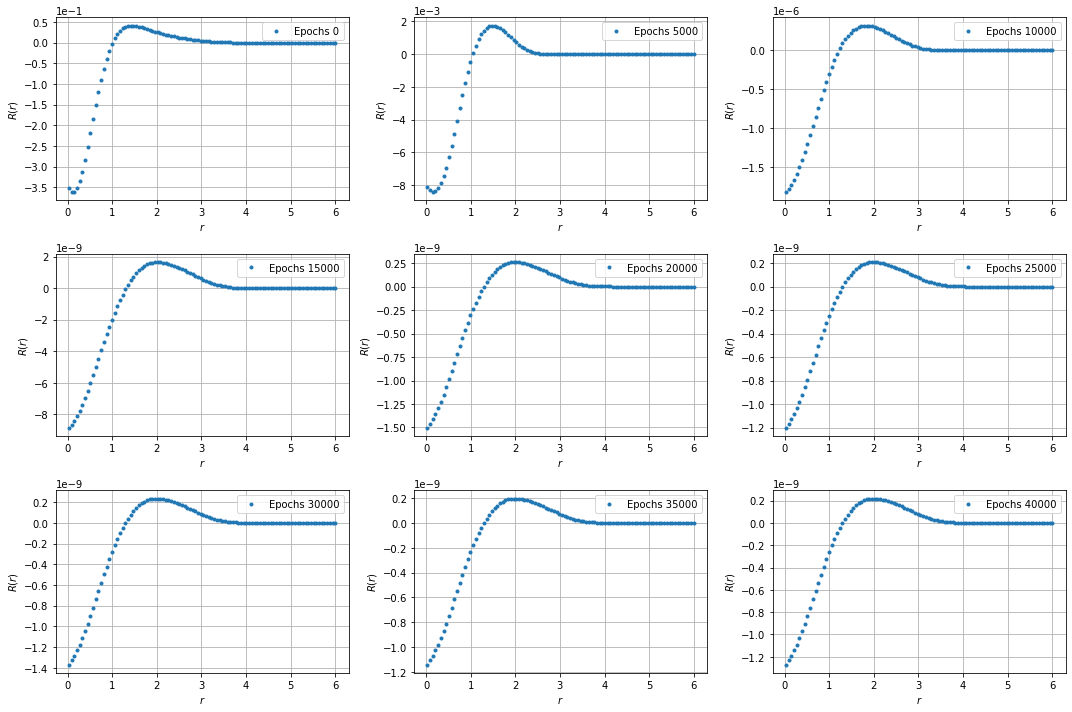

In [11]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]
fig, axs = plt.subplots(3,3,figsize=(15,10))

fil = 0
col = 0
for i in range(0,9):
    yy = Phis_t[50*i]
    yy = yy.reshape((200,1))
    axs[fil,col].plot(rr[100:], np.divide(yy[100:], rr[100:]), ".", label=f"Epochs {epochs[50*i]}")
    axs[fil,col].set_xlabel("$r$")
    axs[fil,col].set_ylabel("$R(r)$")
    axs[fil,col].legend(loc="best")
    axs[fil,col].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[fil,col].grid()
    if col == 2:
       col = 0
       fil = fil+1
    else:
       col = col+1
plt.tight_layout()
plt.show()  

In [12]:
Es

array([3.9328032 , 3.2036858 , 3.1530426 , 3.1557782 , 3.1586592 ,
       3.1628492 , 3.1666384 , 3.208234  , 3.1631806 , 3.1726136 ,
       3.5891345 , 3.2846334 , 3.2493262 , 3.2305102 , 3.219468  ,
       3.2112935 , 3.2041469 , 3.197673  , 3.1915917 , 3.1858199 ,
       3.180849  , 3.1769989 , 3.1741762 , 3.1721282 , 3.170614  ,
       3.1694272 , 3.168357  , 3.167295  , 3.1662977 , 3.1654677 ,
       3.1648428 , 3.1644113 , 3.1641307 , 3.1639552 , 3.1638505 ,
       3.163805  , 3.1639183 , 3.1658905 , 3.1675353 , 3.1689506 ,
       3.1707134 , 3.172897  , 3.1756775 , 3.1793575 , 3.1844542 ,
       3.1919649 , 3.2040458 , 3.2267628 , 3.2937624 , 4.0649066 ,
       2.7151196 , 2.2424788 , 2.1760356 , 2.0059843 , 2.2645032 ,
       2.123088  , 1.9903505 , 1.8676698 , 1.7669221 , 1.7869365 ,
       1.7023338 , 2.3460286 , 1.8668041 , 1.7249078 , 1.6207696 ,
       1.5513397 , 1.5344363 , 1.4811733 , 1.4548963 , 1.6215434 ,
       1.4585367 , 1.3994379 , 1.4977463 , 1.3722026 , 1.55538

In [13]:
np.mean(Es)

0.99309075

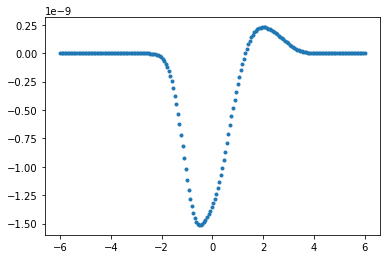

In [14]:
R_1 = torch.divide(Phi_t(R_train), R_train)
plt.plot(R_train.detach().numpy(), R_1.detach().numpy(), ".")

In [15]:
norm1 = torch.trapezoid(R_1[100:]**2,R_train[100:],dim=0)
norm1 = norm1.detach()
norm1

tensor([8.4277e-19])

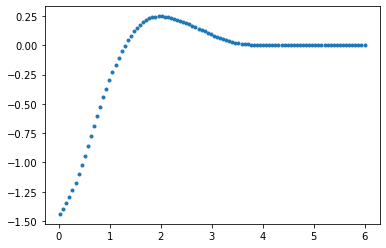

In [16]:
R_1 = R_1/torch.sqrt(norm1)
plt.plot(R_train.detach().numpy()[100:], R_1.detach().numpy()[100:], ".")

In [17]:
torch.trapezoid(R_1[100:]**2,R_train[100:],dim=0)

tensor([1.0000], grad_fn=<DivBackward1>)